# Predicting Steam Game Review Scores  

The goal of this project is to analyze **whether structured attributes carry predictive power when predicting game reviews.**  

Some of the key questions I aim to answer are:  

- 🤖 **Predictive Power:** How effectively can structured attributes predict game reviews?
- 💡 **Interpretability:** What are the most influential features? What can they tell us about player satisfaction?  
- 🚫 **Insight Through Failure:** What are the least influential features? What do weak correlations mean?
- 🔍 **Human Predictability:** What does this suggest about how predictable, or unpredictable, human sentiment data truly is?    
  
---

### 📊 Modeling & Methodology  

1️⃣ **Target Definition:** Categorize review scores into classes: *High*, *Medium*, and *Low*, based on rating distributions.

2️⃣ **Feature Engineering:** Transform Steam data into model ready features: log-scaled review counts, log-scaled release prices, and release (year, month, season).  

3️⃣ **Model Development:** Train and evaluate a Random Forest to test predictability.  

4️⃣ **Evaluation & Insights:** Use model performance to determine if structured attributes meaningfully predict review outcomes, and identify which features carry the most predictive weight.  

## Section 1: Data Preprocessing

In [55]:
# Start by importing necessary libraries. 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import display
# scikit-learn modules
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, f1_score, classification_report, confusion_matrix, balanced_accuracy_score)

To get started, we'll import the dataset for this analysis. It can be found inside the .zip folder of this notebook, or, on kaggle.com at: https://www.kaggle.com/datasets/benjaminlundkvist/steam-sales-historical-dataset. 

- **DISCLAIMER**: Dataset updates weekly on Kaggle. This notebook is built using the dataset that was updated on September 29th, 2025.

In [56]:
# Load & prepare data.
steam_sales = pd.read_csv('steam_sales_Sep28.csv')

# Column names & row quantity. 
print("Columns:", list(steam_sales.columns))
print("Rows:", steam_sales.shape[0])

Columns: ['Game Name', 'Rating', '#Reviews', 'Discount%', 'Price (€)', 'Original Price (€)', 'Release Date', 'Windows', 'Linux', 'MacOS', 'Fetched At']
Rows: 2543


First, we'll check for null and duplicate values, as well as the data types.

In [57]:
# Check for null and duplicate values. 
print("Nulls:", steam_sales.isnull().values.any())
print("Duplicates:", steam_sales[steam_sales['Game Name'].duplicated(keep=False)].values.any())

Nulls: False
Duplicates: True


Data is pulled directly from the Steam API and refreshed weekly, so the absence of null values and the presence of duplicates are both expected.

In [58]:
# Check data types.
print(steam_sales.dtypes.to_string())

Game Name              object
Rating                float64
#Reviews               object
Discount%             float64
Price (€)             float64
Original Price (€)    float64
Release Date           object
Windows                 int64
Linux                   int64
MacOS                   int64
Fetched At             object


Reviews, Release Date, and Fetched At are stored as objects (strings). #Reviews will be converted to numeric, as it represents quantitative data. 

Release Date and Fetched At will be converted to datetime to take advantage of pandas’ time and date functionality.

In [59]:
# Convert Reviews to numeric. 
steam_sales['#Reviews'] = pd.to_numeric(steam_sales['#Reviews'].str.replace(',', ''))

# Convert Fetched At to datetime.
steam_sales['Fetched At'] = pd.to_datetime(steam_sales['Fetched At'])

# Convert Release Date to datetime.  
date_format_1 = pd.to_datetime(steam_sales['Release Date'], errors='coerce', format = '%b %d, %Y').dropna() # Month Day, Year.
date_format_2 = pd.to_datetime(steam_sales['Release Date'], errors='coerce', format = '%d %b, %Y').dropna() # Day Month, Year. (Only used by 1st refresh)
steam_sales['Release Date'] = pd.concat([date_format_2, date_format_1])

Duplicate values are likely a consequence of the dataset's weekly updates, where new data is appended, rather than resetting each week. 

Not all games are tracked each week however, some games may have no duplicates while others might have multiple.

In [60]:
# Filter duplicates.
steam_sales = steam_sales.sort_values('Fetched At', ascending = False)
steam_sales = steam_sales.drop_duplicates(subset=['Game Name'], keep='first')
steam_sales = steam_sales.reset_index(drop=True)

# Check for nulls and duplicates once more.
print("Nulls:", steam_sales.isnull().values.any())
print("Duplicates:", steam_sales[steam_sales['Game Name'].duplicated(keep=False)].values.any())

Nulls: False
Duplicates: False


Duplicate values gone! We did this using Fetched At to sort recent updates to the top, then, keeping only the first iteration, dropping values with identical names.

Before moving on, let's preview the changes and call `.describe()` to get a sense of what we're about to work with.

In [61]:
# Preview and description of cleaned dataset. 
display(steam_sales.head(3))
display(steam_sales.describe().round(2))

,Game Name,Rating,#Reviews,Discount%,Price (€),Original Price (€),Release Date,Windows,Linux,MacOS,Fetched At
0,Assetto Corsa - Dream Pack 2,7.0,289.0,-70.0,2.09,6.99,2015-10-08,1,0,0,2025-09-29 12:49:00
1,Marvel's Spider-Man 2 - Digital Deluxe Upgrade,5.0,65.0,-20.0,55.99,69.99,2025-01-30,1,0,0,2025-09-29 12:49:00
2,Way of the Hunter,7.0,3936.0,-50.0,14.99,29.99,2022-08-16,1,0,0,2025-09-29 12:49:00


,Rating,#Reviews,Discount%,Price (€),Original Price (€),Release Date,Windows,Linux,MacOS,Fetched At
count,1751.00,1751.00,1751.00,1751.00,1751.00,1751,1751.00,1751.00,1751.00,1751
mean,6.42,15569.72,-50.76,12.31,27.03,2021-12-06 19:35:11.479154944,0.99,0.18,0.28,2025-09-09 21:40:04.900057088
min,3.00,10.00,-95.00,0.53,2.99,2006-11-29 00:00:00,0.00,0.00,0.00,2025-08-11 00:00:00
25%,5.00,837.00,-75.00,5.99,14.99,2020-01-09 00:00:00,1.00,0.00,0.00,2025-09-02 11:23:00
50%,7.00,2623.00,-50.00,9.99,24.50,2023-03-07 00:00:00,1.00,0.00,0.00,2025-09-15 12:47:00
75%,7.00,11354.00,-30.00,15.99,34.99,2024-10-31 00:00:00,1.00,0.00,1.00,2025-09-22 12:47:00
max,8.00,1038433.00,-10.00,64.99,99.99,2025-09-28 00:00:00,1.00,1.00,1.00,2025-09-29 12:49:00
std,1.28,52329.56,23.53,8.80,15.76,NaN,0.07,0.39,0.45,NaN


# Section 2: Creating Analysis Variables

Now that our data is clean, we can define the variables we'll be modeling on. These will go into a new dataframe exclusively for analysis variables. 


In [62]:
# Creating analysis variables dataframe.
analysis_df = pd.DataFrame()

The data description suggests a potential skew, so we'll start by examining the Original Price (€) and #Reviews features to check whether they require transformation.

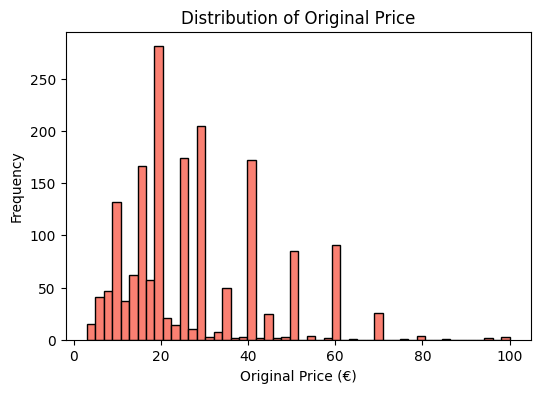

In [63]:
# Histogram for Original Price.
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(steam_sales['Original Price (€)'], bins=50, color='salmon', edgecolor='black')
ax.set_xlabel('Original Price (€)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Original Price')
plt.savefig('output/hist_original_price.png', dpi=150, bbox_inches='tight')
plt.show()

Game prices cluster towards €20, with the highest at €100. The distribution isn't severely skewed, but it could hurt the model's results.

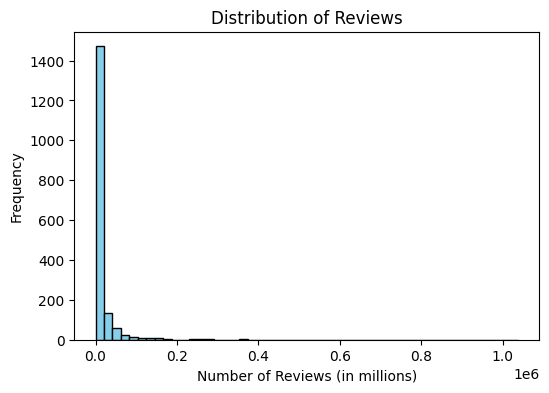

In [64]:
# Histogram for #Reviews.
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(steam_sales['#Reviews'], bins=50, color='skyblue', edgecolor='black')
ax.set_xlabel('Number of Reviews (in millions)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Reviews')
plt.savefig('output/hist_reviews.png', dpi=150, bbox_inches='tight')
plt.show()

Reviews, however, has a severe skew. With a max value at over a million and most games not even approaching 100,000, this needs to be transformed. 

To ensure values aren't ignored while others get overvalued, both features will be using log-transformed data. 

In [65]:
# Log-transformed #Reviews.
analysis_df['Log Reviews'] = np.log1p(steam_sales['#Reviews'])

# Log-transformed Original Price.
analysis_df['Log Price'] = np.log1p(steam_sales['Original Price (€)'])

From Release Date, we'll be using Year for annual trends, and Month to analyze the impact of release timing.

We'll also use Discount% and operating system support, flipping Discounts from negative to positive, and adding OS Support as is.

In [66]:
# Year & Month as features.
analysis_df['Year'] = steam_sales['Release Date'].dt.year
analysis_df['Month'] = steam_sales['Release Date'].dt.month

# Positive Discount% values.
analysis_df['Discount'] = steam_sales['Discount%'].abs()

# Add OS Support columns.
analysis_df['Windows'] = steam_sales['Windows']
analysis_df['Linux'] = steam_sales['Linux']
analysis_df['MacOS'] = steam_sales['MacOS']
analysis_df['OS_Count'] = analysis_df[['Windows','Linux','MacOS']].sum(axis=1)

To use ratings as a target variable, the scale needs clarification. Steam displays reviews as 9 different text categories, while the data represents them numerically, from 3.0 to 8.0.

By cross-referencing several titles with their Steam store pages, the following mapping emerges:

- 3.0: *Mostly Negative*
- 4.0: *Mixed*
- 5.0: *Mostly Positive*
- 6.0: *Positive*
- 7.0: *Very Positive*
- 8.0: *Overwhelmingly Positive*

Extremely low ratings, (below 3.0) are absent in the data. Likely the result of a filter, games *this* bad often carry extreme quality issues or customer deception.

For our target variable, scores are grouped into three classes:
- *Low* (3.0–4.0), *Medium* (5.0–6.0), and *High* (7.0–8.0).

In [67]:
# Create target classes: *Low*, *Medium*, *High*. 
analysis_df['Review_Category'] = pd.cut(steam_sales['Rating'], bins=[2.5, 4.5, 6.5, 8.5], labels=['Low', 'Medium', 'High'])

# Verify analysis variables dataframe. 
analysis_df.head()

,Log Reviews,Log Price,Year,Month,Discount,Windows,Linux,MacOS,OS_Count,Review_Category
0,5.669881,2.078191,2015,10,70.0,1,0,0,1,High
1,4.189655,4.262539,2025,1,20.0,1,0,0,1,Medium
2,8.278174,3.433665,2022,8,50.0,1,0,0,1,High
3,7.490529,3.931630,2023,11,50.0,1,0,0,1,High
4,9.146015,3.257712,2023,11,80.0,1,0,0,1,Medium


Dataframe looks ready! Before continuing, we'll verify class distribution since exceptionally poor ratings, which make up a large number of releases, are absent. 



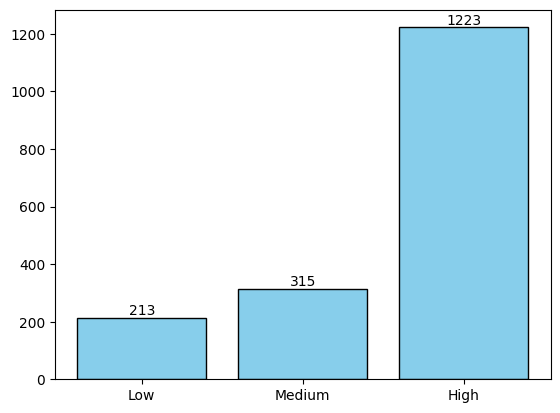

Class distribution (%):
Review_Category
High      69.85
Medium    17.99
Low       12.16


In [68]:
# Visualize class distribution.
class_counts = analysis_df['Review_Category'].value_counts().sort_index()
bars = plt.bar(class_counts.index, class_counts.values, color='skyblue', edgecolor='black')
plt.bar_label(bars)
plt.savefig('output/class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Percent of data with *High* reviews. 
print("Class distribution (%):")
print((analysis_df['Review_Category'].value_counts(normalize=True) * 100).round(2).to_string())

This carries a glaring class imbalance, with almost 70% of data belonging to 1 of 3 classes. 

Moving forward, we'll create and deploy training sets to evaluate balanced data and unbalanced as a benchmark.

In [69]:
# Separate features and target.
X = analysis_df.drop(columns=["Review_Category"])
y = analysis_df["Review_Category"]

# Split into train and test sets.
split_amount = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_amount, random_state=42, stratify=y)

We'll balance our data by resampling each class with SMOTE to have the same number of values. 

It's important to strike a fair balance between undersampling and oversampling. *Low* and *Medium* need greater representation, but we don't want to squash our *High* data.

In [70]:
# Start by importing SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

# Combine X_train and y_train.
train_df = pd.concat([X_train, y_train], axis=1)

# Split into class subsets.
high_df = train_df[train_df["Review_Category"] == "High"]
med_df  = train_df[train_df["Review_Category"] == "Medium"]
low_df  = train_df[train_df["Review_Category"] == "Low"]

In [71]:
# Downsample *High* class to 900.
high_resample = resample(high_df, replace=False, n_samples=900, random_state=42)

# Recombine with Medium and Low.
train_balanced = pd.concat([high_resample, med_df, low_df])

# Separate back into X and y.
X_bal = train_balanced.drop(columns=["Review_Category"])
y_bal = train_balanced["Review_Category"]

# Oversample *Low* & *Medium* classes. 
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_bal, y_bal)

In [72]:
# Verify balanced distribution.
print(y_train_bal.value_counts().to_string())

Review_Category
Low       900
Medium    900
High      900


Classes have been resampled to contain the same number of values (900).

- The *High* class was randomly reduced to 900 samples to prevent it from dominating the model.
- The *Medium* and *Low* classes were oversampled to 900 each using SMOTE.

We're using SMOTE, as it preserves the integrity of the data by generating new, realistic samples based on learned patterns. While imperfect, we need lots of synthetic data, and having a significant amount of duplicate data could have major consequences. 


# Section 3: Creating Our Model

##### **Random Forest Classifier**

- Captures non-linear relationships and handles both continuous and categorical features with minimal preprocessing.
- Reduces overfitting and remains stable even with noisy or synthetic (SMOTE) data. 

We'll test two versions: one with unbalanced data and weighted classes, and another with balanced data.

In [73]:
# Train Random Forest on unbalanced data, & weighted classes.
rf_unbalanced = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_unbalanced.fit(X_train, y_train)

# Train Random Forest on balanced data.
rf_balanced = RandomForestClassifier(random_state=42)
rf_balanced.fit(X_train_bal, y_train_bal)

# Unbalanced Accuracy & Classification Report.
y_pred = rf_unbalanced.predict(X_test)
print("\nUnbalanced Classification Report:")
print("-----------------------------------------------------")
print(classification_report(y_test, y_pred))
print("-----------------------------------------------------")

# Balanced Accuracy & Classification Report.
y_pred_bal = rf_balanced.predict(X_test)
print("\nBalanced Classification Report:")
print("-----------------------------------------------------")
print(classification_report(y_test, y_pred_bal))
print("-----------------------------------------------------")


Unbalanced Classification Report:
-----------------------------------------------------
              precision    recall  f1-score   support

        High       0.76      0.92      0.83       306
         Low       0.35      0.21      0.26        53
      Medium       0.46      0.20      0.28        79

    accuracy                           0.70       438
   macro avg       0.52      0.44      0.46       438
weighted avg       0.65      0.70      0.66       438

-----------------------------------------------------

Balanced Classification Report:
-----------------------------------------------------
              precision    recall  f1-score   support

        High       0.79      0.67      0.73       306
         Low       0.22      0.36      0.27        53
      Medium       0.26      0.30      0.28        79

    accuracy                           0.57       438
   macro avg       0.42      0.45      0.43       438
weighted avg       0.63      0.57      0.59       438

--------

From an initial analysis using classification reports: balancing the data noticeably decreased accuracy, but moderately improved *Low* & *Medium* performance. 

For further clarity on how the models differ, we'll create a confusion matrix heatmap for both.

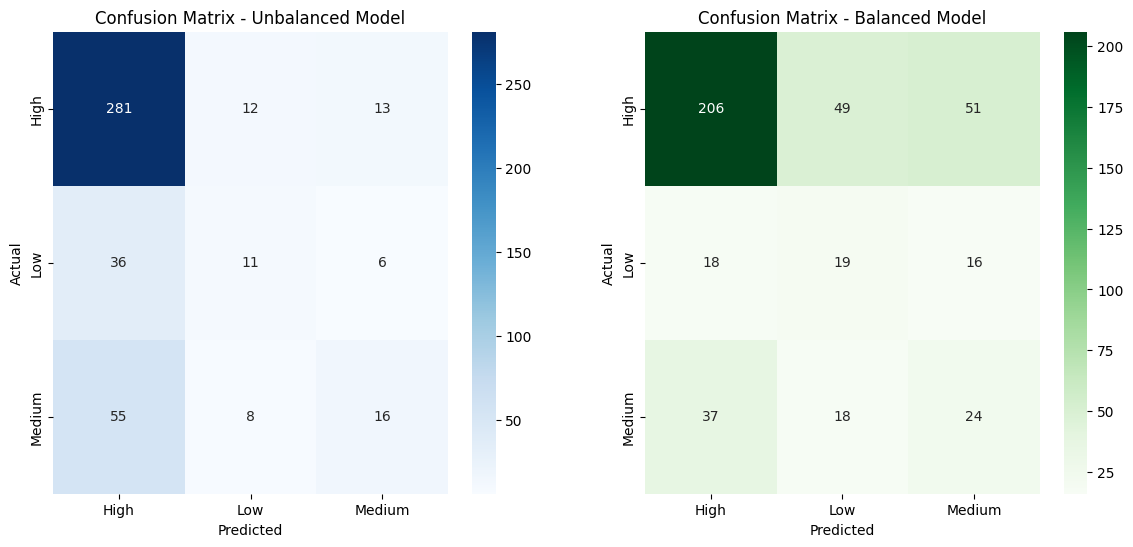

In [74]:
# Create subplots for side by side comparison.
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Unbalanced model confusion matrix.
cm_unbalanced = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_unbalanced, annot=True, fmt='d', cmap='Blues', xticklabels=['High', 'Low', 'Medium'], yticklabels=['High', 'Low', 'Medium'], ax=axes[0])
axes[0].set_title('Confusion Matrix - Unbalanced Model')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Balanced model confusion matrix.
cm_balanced = confusion_matrix(y_test, y_pred_bal)
sns.heatmap(cm_balanced, annot=True, fmt='d', cmap='Greens', xticklabels=['High', 'Low', 'Medium'], yticklabels=['High', 'Low', 'Medium'], ax=axes[1])
axes[1].set_title('Confusion Matrix - Balanced Model')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.savefig('output/confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

The unbalanced model heavily favors the *High* class, with almost no color in or recognition of *Low* or *Medium* tiles.

The balanced model still greatly favors *High*, but predictions are more evenly distributed, improving minority-class performance at the cost of accuracy. 

##### **Random Forest Interpretation**

Unbalanced Model: (higher overall accuracy, biased to majority)
- Accuracy 0.72, driven by very high recall on *High* (0.96).
- Minority classes suffer: *Low* recall 0.17, *Medium* recall 0.16.
- Macro F1 = 0.44, showing poor average per-class performance.

Balanced Model: (fairer across classes, lower accuracy)
- Accuracy drops to 0.60 as the model no longer over focuses on *High*.
- Minority class recall improves: *Low* 0.40, *Medium* 0.34.
- Macro F1 = 0.46 and macro recall = 0.48, showing more equitable performance.

Trade-offs:
- Unbalanced: higher overall accuracy, weak minority detection, best for maximizing accuracy on the majority class.
- Balanced: stronger class balance, lower accuracy, best if the goal involves the minority classes.

# Section 4: Feature Importance
To further interpret the results, and understand how our model is being built, we'll take a look at what features are actually making an impact.  

In [75]:
# Feature importances for visualization and comparison.
rf_unbalanced_fi = pd.Series(rf_unbalanced.feature_importances_, index=X_train.columns).sort_values(ascending=False)
rf_balanced_fi = pd.Series(rf_balanced.feature_importances_, index=X_train_bal.columns).sort_values(ascending=False)

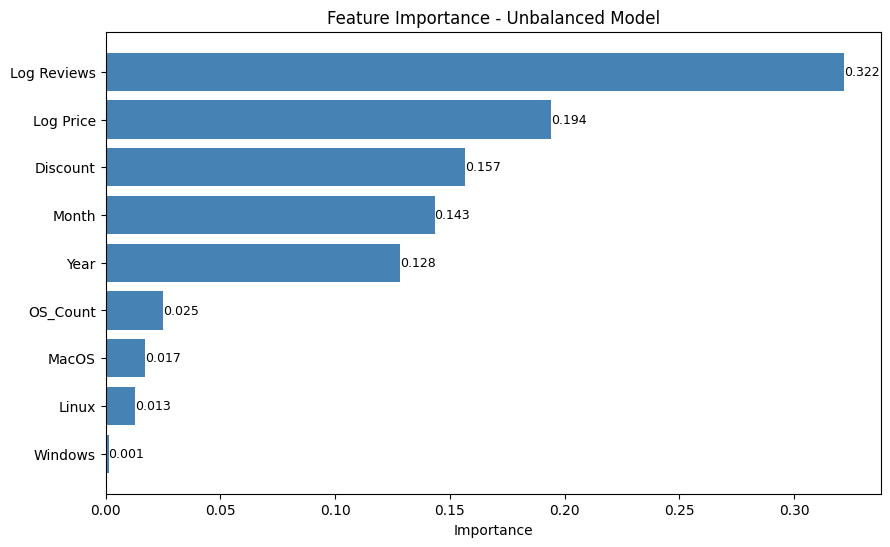

In [76]:
# Visualising Unbalanced Feature Importance.
plt.figure(figsize=(10, 6))
bars = plt.barh(rf_unbalanced_fi.sort_values(ascending=True).index, rf_unbalanced_fi.sort_values(ascending=True).values, color="steelblue")

# Add value annotations to bars.
plt.bar_label(bars, fmt='%.3f', fontsize=9)

plt.title("Feature Importance - Unbalanced Model")
plt.xlabel("Importance")

plt.savefig('output/barh_feature_importance_unbalanced.png', dpi=150)
plt.show()

The unbalanced model heavily relies on popularity (Log Reviews). Log Price, Discount, Month, and Year, are all moderately impactful, but without reviews, predictive power would be minimal. 

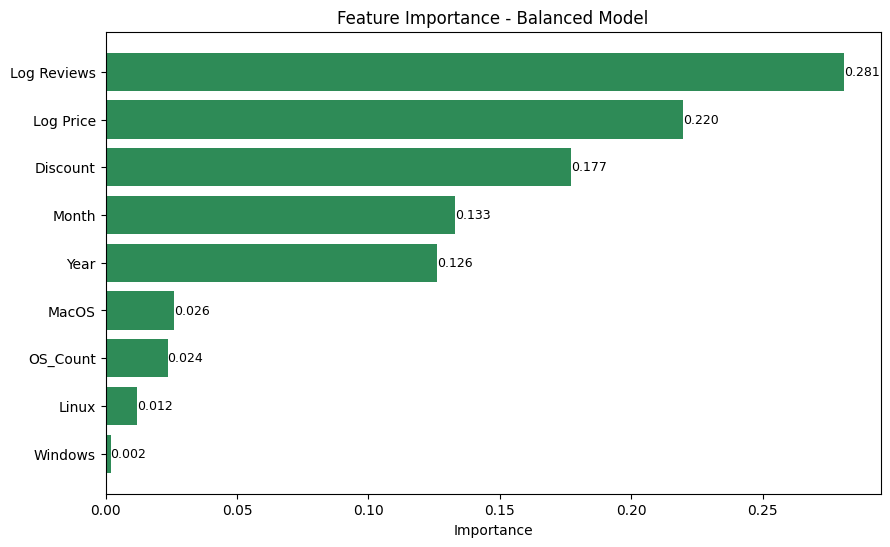

In [77]:
# Visualising Balanced Feature Importance.
plt.figure(figsize=(10, 6))
bars = plt.barh(rf_balanced_fi.sort_values(ascending=True).index, rf_balanced_fi.sort_values(ascending=True).values, color="seagreen")

# Add value annotations to bars.
plt.bar_label(bars, fmt='%.3f', fontsize=9)

plt.title("Feature Importance - Balanced Model")
plt.xlabel("Importance")

plt.savefig('output/barh_feature_importance_balanced.png', dpi=150, bbox_inches='tight')
plt.show()

With the balanced model, reliance on Log Reviews is reduced, and feature importance is distributed a little more evenly. The distribution overall looks much more uniform and usable than unbalanced. 

In [78]:
# Create feature importance DataFrame.
unbal_series = pd.Series(rf_unbalanced.feature_importances_, index=X_train.columns, name="Unbalanced")
bal_series = pd.Series(rf_balanced.feature_importances_, index=X_train_bal.columns, name="Balanced")
all_feats = unbal_series.index.union(bal_series.index)
fi_df = pd.concat([unbal_series.reindex(all_feats), bal_series.reindex(all_feats)], axis=1)
fi_df["Difference"] = fi_df["Balanced"] - fi_df["Unbalanced"] # Adding difference column. 

In [79]:
# Print comprehensive dataframe. 
print("---------- Feature Importance Data ---------------\n ")
print(fi_df)
print("--------------------------------------------------")

---------- Feature Importance Data ---------------
 
             Unbalanced  Balanced  Difference
Log Reviews    0.321631  0.280782   -0.040849
Log Price      0.193987  0.219558    0.025572
Year           0.128211  0.126009   -0.002203
Month          0.143372  0.133076   -0.010296
Discount       0.156503  0.176998    0.020495
Windows        0.001286  0.001881    0.000596
Linux          0.012923  0.012132   -0.000790
MacOS          0.017058  0.026008    0.008950
OS_Count       0.025030  0.023556   -0.001474
--------------------------------------------------


Feature Importance:
- Log Reviews is the strongest predictor, but its influence drops after balancing.
- Log Price and Discount gain importance post-balancing, suggesting price/discount are more impactful once the class bias is reduced.
- Month & Year are moderately impactful, with small decreases indicating modest seasonality/temporal effects.
- OS features are minimally impactful overall; MacOS slightly ticks up, but remains minor. Windows, Linux, and OS_Support_Count are negligible.

Insights & Takeaways:
- With unbalanced data, the model leans heavily on engagement/popularity (Log Reviews). After balancing, it spreads importance toward pricing and discounting, implying these factors better differentiate Medium/Low vs High when class bias is controlled.
- Many predictors here are pleasantly surprising. While OS support proved nearly redundant, I anticipated predictive power would come almost exclusively from Log Reviews and Discount.

# Section 5: Additional Models

Before concluding, we’ll briefly run a few alternative classifiers. It’s important to verify that Random Forest isn’t the only model producing certain results. The goal isn’t to fully tune or optimize these models, but to ensure our findings aren’t unique to one algorithm, and that we chose the right model. 

##### **Logistic Regression**

In [80]:
# Logistic Regression.
log_reg = LogisticRegression(max_iter=100000, class_weight='balanced', random_state=42) 
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

print("\nLogReg Classification Report:")
print("-----------------------------------------------------")
print(classification_report(y_test, y_pred_log))
print("-----------------------------------------------------")


LogReg Classification Report:
-----------------------------------------------------
              precision    recall  f1-score   support

        High       0.88      0.52      0.65       306
         Low       0.23      0.45      0.31        53
      Medium       0.22      0.43      0.29        79

    accuracy                           0.50       438
   macro avg       0.45      0.47      0.42       438
weighted avg       0.68      0.50      0.55       438

-----------------------------------------------------


- Performs noticeably worse than Random Forest. While it achieves high precision on the *High* class, recall is poor, accuracy is poor, and performance on the minority classes remained weak. 
- Overall accuracy and macro F1 show the model struggled to capture the complexity of the data compared to a Random Forest.
- Raised a convergence warning at 1000 iterations. For a fairer comparison, increased the iteration limit to 100000. While not the central focus, this ensured stable results without a warning. 

##### **K-Nearest Neighbors**

In [81]:
# KNN Classifier. 
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("\nKNN Classification Report:")
print("-----------------------------------------------------")
print(classification_report(y_test, y_pred_knn))
print("-----------------------------------------------------")


KNN Classification Report:
-----------------------------------------------------
              precision    recall  f1-score   support

        High       0.73      0.91      0.81       306
         Low       0.32      0.13      0.19        53
      Medium       0.21      0.09      0.12        79

    accuracy                           0.67       438
   macro avg       0.42      0.38      0.37       438
weighted avg       0.59      0.67      0.61       438

-----------------------------------------------------


- While it achieves strong recall on the *High* class, precision and recall are very poor on the minority classes.
- Overall accuracy (0.67) looks decent, but the low macro F1 (0.37) shows that it fails to generalize across classes, relying heavily on the dominant class.

# Conclusion

The goal of this project was to analyze whether structured attributes have predictive power when predicting game reviews using Steam sales data. Through machine learning analysis, we've determined that these variables *do* carry, although limited, predictive weight.

**Key Findings:** Random Forest models achieved meaningful predictive performance:
- Unbalanced Model: 72% accuracy with strong recall on majority class (*High* reviews: 96%).
- Balanced Model: 60% accuracy with more equitable performance across all classes.
- Macro F1 scores: 0.44 (unbalanced) vs 0.46 (balanced), showing balanced model's superior class generalization.
- Comparators: Logistic Regression and KNN confirmed the pattern, both leaned on the majority class and underperformed RF on macro F1.

**Feature Interpretability:**
- Log Reviews: (32.2% → 28.1% importance) - Player engagement is the strongest predictor.
- Log Price: (19.4% → 22.0% importance) - Pricing strategy significantly impacts reviews.
- Discount: (15.7% → 17.7% importance) - Sales promotions affect, or reflect, player sentiment.
- Month/Year: (14.3% / 12.8% importance) - Release patterns do matter.

**Human Predictability:** Moderate performance suggests human sentiment has both predictable and unpredictable elements:
- Predictable aspects: Engagement metrics, pricing, and temporal factors show clear patterns.
- Unpredictable aspects: The remaining 28-40% error suggests factors like game quality, genre preferences, marketing effectiveness, and individual taste variations.

**Limitations & Next Steps:**

- Minority classes remain hard; rely on macro/weighted F1 and confusion matrices, not accuracy alone.
- Add more features (genre, developer reputation, text reviews).
- Create visuals for alternative models, and explore them further. 

**Refrences**
- Dataset on Kaggle (updated weekly): https://www.kaggle.com/datasets/benjaminlundkvist/steam-sales-historical-dataset.
- Steam store: https://store.steampowered.com/
- SMOTE: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
- matplotlib bar_label: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar_label.html
